# Amne Data Science Technical Challenge
## Data exploration and model design
Ryan Peabody <br>
May 1, 2018

In [1]:
# Start by importing packages
import numpy as np
import scipy
import pandas as pd
import math

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline



For this assignment, we're going to be using the King County House Sales dataset, giving home sales prices around Seattle, WA between May 2014 and May 2015. Data are available at https://www.kaggle.com/harlfoxem/housesalesprediction/data

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


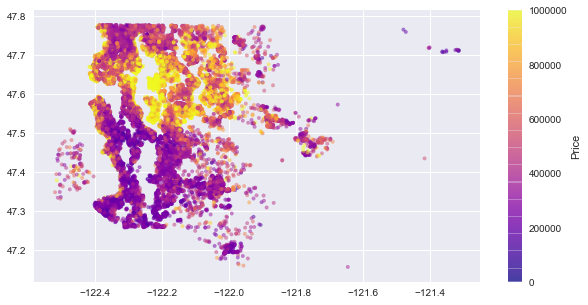

In [2]:
# Read in data, examine parameters

df = pd.read_csv('../Data/King_County/kc_house_data.csv')
print(df.columns)

plt.figure(figsize = (10, 5))
plt.scatter(x = df.long, y = df.lat, c = df.price, marker = '.', cmap = 'plasma', vmin = 0, vmax = 1e6, 
            alpha = 0.5)
plt.colorbar(label = 'Price')
plt.show()

Okay, so it looks like we have some data that can be generalizable to our model, and some that can't. King County provides "condition" and "grade" data. Those might be something that we can include at a later date, but right now our goal is to predict housing price given information from our users. Condition is not something we are going to trust them on. Similarly, home ID is not of interest to us. The variable 'sqft_lot15' gives the total lot size in 2015, making the original lot size a little redundant. Also, we have lat and lon, so we can get rid of zipcode. And while a house being viewed or not might affect price, it is not really useful for the product we are trying to build right now. Also, square footage usually does not include the basement, so we can get rid of total square footage in favor of the "sqft_above" variable, which only includes non-basement rooms.

In [3]:
df_new = df.drop(['condition', 'grade', 'id', 'sqft_lot', 'zipcode', 'view', 'sqft_living', 'sqft_living15'], 
                 axis = 1)

There are a couple of instances where a home's listed renovation year is more recent its sale year. Renovations might have changed the lot size and living room size, so we drop those cases.

In [4]:
idx = df_new['yr_renovated'] > pd.to_numeric(df_new['date'].str[:4])

There are also some weird properties that have 0 bedrooms or 0 bathrooms listed. We'll remove them.

In [5]:
idx_1 = df_new['bathrooms'] == 0 
idx_2 = df_new['bedrooms'] == 0
idx = idx_1 | idx_2
df_new.drop(idx, axis = 0, inplace = True)

Date is a little puzzling. Obviously we are onyl dealing with one year worth of data, but there is documented seasonality in housing prices. Let's pull the month each home was sold out, while removing year and date.

In [6]:
df_new['month'] = pd.to_numeric(df_new['date'].str[4:6])
df_new.drop('date', axis = 1, inplace = True)

And take a look at the correlation between each of our variables and price

In [7]:
y = df_new['price']
corr = {}
for ii in df_new.columns:
    if ii != 'price':
        x = df_new[ii]
        corr[ii] = scipy.stats.pearsonr(x, y)[0]
corr = pd.DataFrame(corr, index  =['Correlation with price']).T
corr.sort_values(by = 'Correlation with price', inplace = True, ascending = False)
display(corr)

,Correlation with price
sqft_above,0.605559
bathrooms,0.525114
sqft_basement,0.323799
bedrooms,0.308341
lat,0.307005
waterfront,0.266371
floors,0.256772
yr_renovated,0.126495
sqft_lot15,0.082438
yr_built,0.053991


In [8]:
a = df_new.yr_renovated != 0
a = a.astype(int)
print(scipy.stats.pearsonr(a, df_new.price)[0])

0.126153530616


Whether or not a home has been renovated gives about the same correlation with price than the year it was renovated. However, here we are replacing it as a binary variable because it is more likely that a homeowner knows if the home has ever been renovated or not.

In [9]:
df_new['renovated'] = df_new['yr_renovated'] != 0
df_new['renovated'] = df_new['renovated'].astype(int)
df_new.drop('yr_renovated', axis = 1, inplace = True)

Let's take a look at everything.

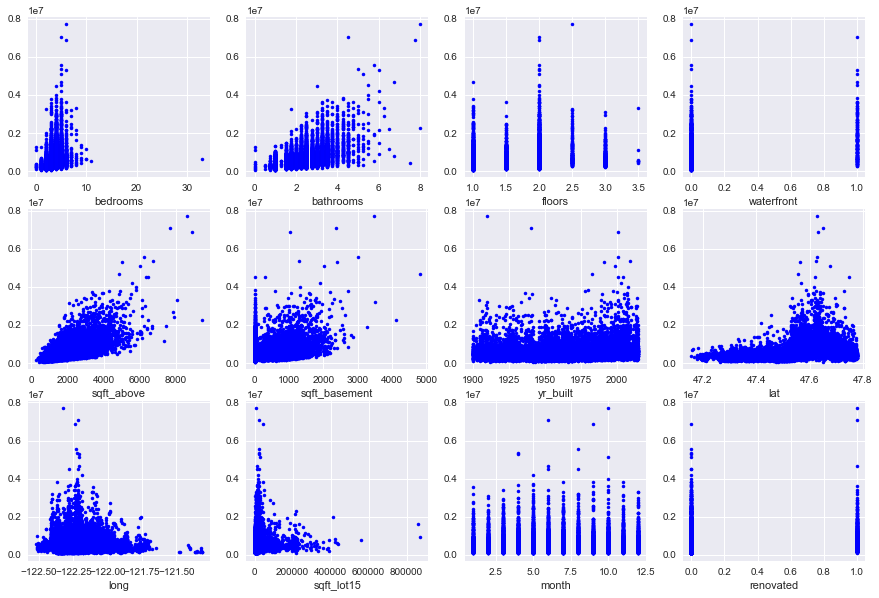

In [10]:
fig, ax = plt.subplots(figsize = (15, 10))
y = df_new.price
idx = 1;
for ii in df_new.columns:
    if ii != 'price':
        x = df_new[ii]
        plt.subplot(3, 4, idx)
        plt.plot(x, y, 'b.')
        plt.xlabel(ii)
        idx += 1


We can see some outliers right now that we might wish to get rid of. 

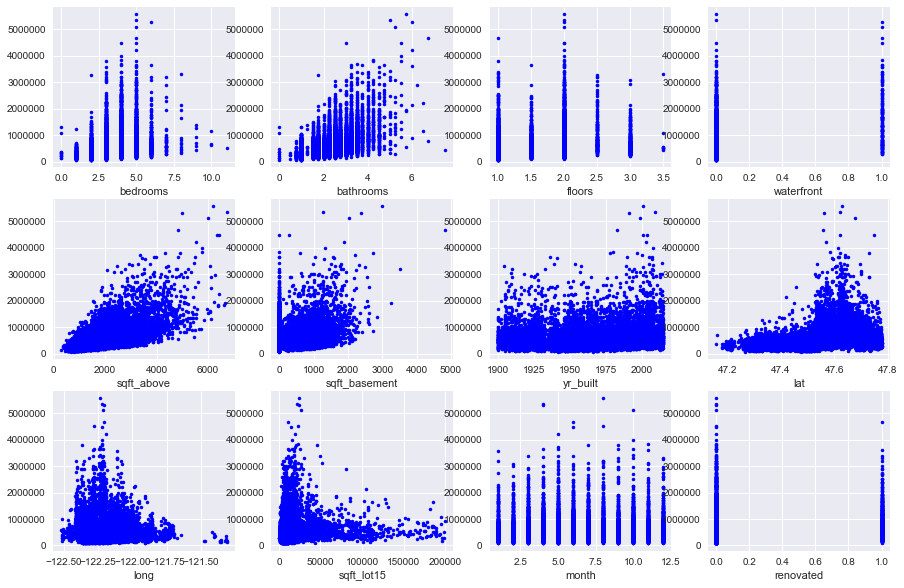

In [11]:
# Get rid of the houses with over 20 bedrooms
idx = df_new['bedrooms'] >= 20
df_new = df_new.loc[~idx]

# And the houses with very large lots
idx = df_new['sqft_lot15'] >= 200000
df_new = df_new.loc[~idx]

# And the houses with huge square footage
idx = df_new['sqft_above'] >= 7000
df_new = df_new.loc[~idx]

# Visualize the data again
fig, ax = plt.subplots(figsize = (15, 10))
y = df_new.price
idx = 1;
for ii in df_new.columns:
    if ii != 'price':
        x = df_new[ii]
        plt.subplot(3, 4, idx)
        plt.plot(x, y, 'b.')
        plt.xlabel(ii)
        idx += 1

Now we can start trying to model our data.

In [12]:
y = df_new.price.values
X = df_new.drop('price', axis = 1).values
df_new.to_csv('../Data/King_County/kc_house_data_cleaned.csv')

Split data for training and testing

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

Some of the models we are testing require normalized data.

In [14]:
X_train_scale = preprocessing.scale(X_train)
X_test_scale = preprocessing.scale(X_test)

We will start by testing ordinary least squares, lasso, and ridge regression against each other

In [15]:
# Ordinary least squares

# Train model and predict on test set
lin_reg = linear_model.LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_ols = lin_reg.predict(X_test)
print('Ordinary Least Squares')
print('RMSE: %.2f' % np.sqrt(mean_squared_error(y_test, y_pred_ols)))
print('r^2: %.2f' % r2_score(y_test, y_pred_ols))
print('')

#------------------------------------------------------------------------------------------------------------------
# Lasso regression

# Train model and predict on test set
las_reg = linear_model.Lasso(alpha = 0.5, max_iter = 35000)
las_reg.fit(X_train_scale, y_train)
y_pred_las = las_reg.predict(X_test_scale)
print('Lasso')
print('RMSE: %.2f' % np.sqrt(mean_squared_error(y_test, y_pred_las)))
print('r^2: %.2f' % r2_score(y_test, y_pred_las))
print('')

#------------------------------------------------------------------------------------------------------------------
# Ridge regression

# Train model and predict on test set
rid_reg = linear_model.Ridge(alpha = 1, max_iter = 5000)
rid_reg.fit(X_train, y_train)
y_pred_rid = rid_reg.predict(X_test)
print('Ridge')
print('RMSE: %.2f' % np.sqrt(mean_squared_error(y_test, y_pred_rid)))
print('r^2: %.2f' % r2_score(y_test, y_pred_rid))


Ordinary Least Squares
RMSE: 215635.60
r^2: 0.65

Lasso
RMSE: 215621.16
r^2: 0.65

Ridge
RMSE: 215669.49
r^2: 0.65


None of these are very good, so let's try a couple different models

In [16]:
# Gradient boosting regressor

# Train model and predict on test set
gbr = GradientBoostingRegressor(n_estimators = 100, learning_rate = 0.1, max_depth = 5, random_state = 42, 
                                loss = 'ls')
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)
print('GBR')
print('RMSE: %.2f' % np.sqrt(mean_squared_error(y_test, y_pred_gbr)))
print('r^2: %.2f' % r2_score(y_test, y_pred_gbr))
print('')

#------------------------------------------------------------------------------------------------------------------
# Random forest regressor

# Train model and predict on test set
rfr = RandomForestRegressor(n_estimators = 100, max_depth = 100)
rfr.fit(X_train, y_train)
y_pred_rfr = rfr.predict(X_test)
print('RFR')
print('RMSE: %.2f' % np.sqrt(mean_squared_error(y_test, y_pred_rfr)))
print('r^2: %.2f' % r2_score(y_test, y_pred_rfr))
print('')

#------------------------------------------------------------------------------------------------------------------
# AdaBoostRegressor

# Train model and predict on test set
ada = AdaBoostRegressor(n_estimators = 10, learning_rate = 0.5)
ada.fit(X_train, y_train)
y_pred_ada = ada.predict(X_test)
print('AdaBoost')
print('RMSE: %.2f' % np.sqrt(mean_squared_error(y_test, y_pred_ada)))
print('r^2: %.2f' % r2_score(y_test, y_pred_ada))
print('')


GBR
RMSE: 131469.35
r^2: 0.87

RFR
RMSE: 138046.31
r^2: 0.86

AdaBoost
RMSE: 232407.62
r^2: 0.59



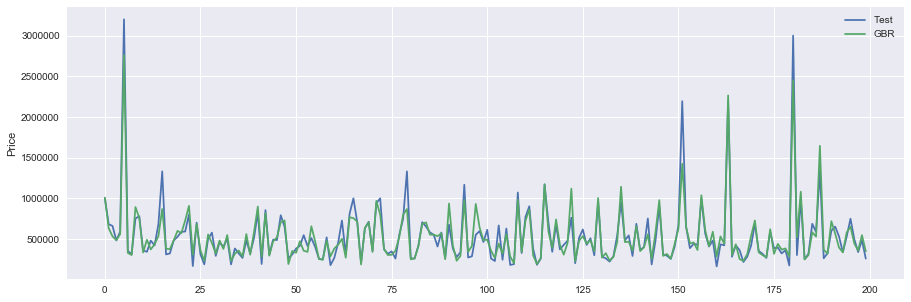

In [17]:
# Plot 200 random sale prices, and the GBR prediction

idx = np.random.randint(0, len(y_test), 200)
y_plot_1 = y_test[idx]
y_plot_2 = y_pred_gbr[idx]

fig = plt.figure(figsize = (15, 5))
L_1 = plt.plot(y_plot_1)
L_2 = plt.plot(y_plot_2)
plt.ylabel('Price')
plt.legend(('Test', 'GBR'))

plt.show()

These are looking better. Gradient boosting regression gives pretty good performance, and it wouldn't be the ***worst*** thing in the world to just apply it semi-blindly to our dataset. But let's see if narrowing our dataset geographically can give us better performance. We might imagine that houses near each other might behave in similar fashions, with respect to price. In a perfect world, we would have price history data and could only examine properties that have historically behaved in a fashion similar to one another, and we could separate neighborhoods by looking at actual connectivity between houses via roads. Right now we are just going to make a first order pass at this, and see if there is some radius around a proprty that gives a better training dataset

In [18]:
# Define the haversine function, giving the great circle distance between two points
def haversine_distance(lon_lat_1, lon_lat_2):
    lon_1, lat_1 = lon_lat_1
    lon_2, lat_2 = lon_lat_2
    radius = 6371e3 # m

    d_lat = math.radians(lat_2 - lat_1)
    d_lon = math.radians(lon_2 - lon_1)
    a = math.sin(d_lat/2) * math.sin(d_lat/2) + math.cos(math.radians(lat_1)) \
        * math.cos(math.radians(lat_2)) * math.sin(d_lon/2) * math.sin(d_lon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

In [19]:
lat = X[:, -5]
lon = X[:, -4]
d_q = [i*int(1e3) for i in range(1, 20)]

num_prop = np.empty([25, len(d_q)])
rmse_ols = np.empty([25, len(d_q)])
r2_ols = np.empty([25, len(d_q)])
rmse_gbr = np.empty([25, len(d_q)])
r2_gbr = np.empty([25, len(d_q)])

# We are going to use 25 random properties, and see how the RMSE and r^2 for OLS regression and GBR change as we 
# increase the radius inside which we build our models, from 1 km to 20 km
for ii in range(0, 25):
    [lat_1, lon_1] = X_test[ii][-5:-3]
    
    distance = []
    for jj in range(0, len(lat)):
        d = haversine_distance([lon_1, lat_1], [lon[jj], lat[jj]])
        distance.append(d)
    df_new['distance'] = distance

    for jj, r in enumerate(d_q):

        # Select all data within a given radius
        idx = df_new['distance'] <= r
        df_local = df_new[idx]
        
        # We only want to try to model groups of at least 50 properties
        if len(df_local) >= 50:
            X_local = df_local.drop(['price', 'distance'], axis = 1).values
            y_local = df_local['price'].values

            # Split data for training and testing
            X_train_local, X_test_local, y_train_local, y_test_local = train_test_split(X_local, y_local, 
                                                                                        test_size = 0.3)

            # OLS
            lin_reg = linear_model.LinearRegression()
            lin_reg.fit(X_train_local, y_train_local)
            y_pred_ols = lin_reg.predict(X_test_local)
            rmse_ols[ii, jj] = np.sqrt(mean_squared_error(y_test_local, y_pred_ols))
            r2_ols[ii, jj] = r2_score(y_test_local, y_pred_ols)

            # GBR
            gbr = GradientBoostingRegressor(n_estimators = 100, learning_rate = 0.5, max_depth = 5, 
                                            random_state = 42, loss = 'ls')
            gbr.fit(X_train_local, y_train_local)
            y_pred_gbr = gbr.predict(X_test_local)
            rmse_gbr[ii, jj] = np.sqrt(mean_squared_error(y_test_local, y_pred_gbr))
            r2_gbr[ii, jj] = r2_score(y_test_local, y_pred_gbr)
            
            num_prop[ii, jj] = len(df_local)
    print('Done with property ', ii+1, ' of ', 25)

Done with property  1  of  25
Done with property  2  of  25
Done with property  3  of  25
Done with property  4  of  25
Done with property  5  of  25
Done with property  6  of  25
Done with property  7  of  25
Done with property  8  of  25
Done with property  9  of  25
Done with property  10  of  25
Done with property  11  of  25
Done with property  12  of  25
Done with property  13  of  25
Done with property  14  of  25
Done with property  15  of  25
Done with property  16  of  25
Done with property  17  of  25
Done with property  18  of  25
Done with property  19  of  25
Done with property  20  of  25
Done with property  21  of  25
Done with property  22  of  25
Done with property  23  of  25
Done with property  24  of  25
Done with property  25  of  25


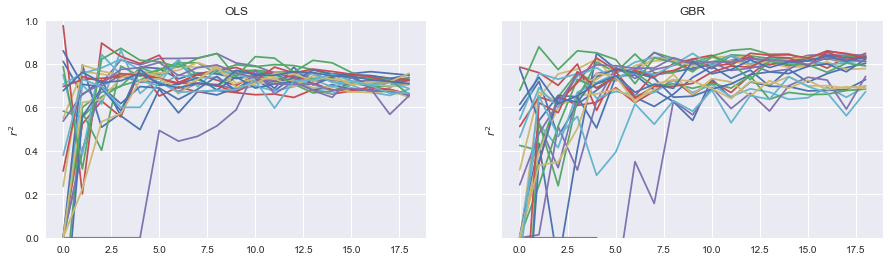

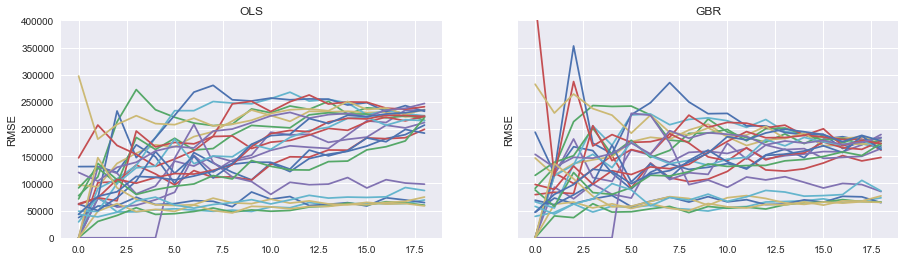

In [20]:
fig, axes = plt.subplots(1, 2, sharex = True, sharey = True)

axes[0].plot(np.transpose(r2_ols))
axes[0].set_title('OLS')
axes[0].set_ylabel('$r^2$')
axes[0].set_ylim(0, 1)

axes[1].plot(np.transpose(r2_gbr))
axes[1].set_title('GBR')
axes[1].set_ylabel('$r^2$')
axes[1].set_ylim(0, 1)

fig.set_figheight(4)
fig.set_figwidth(15)
plt.show()


fig, axes = plt.subplots(1, 2, sharex = True, sharey = True)

axes[0].plot(np.transpose(rmse_ols))
axes[0].set_title('OLS')
axes[0].set_ylabel('RMSE')
axes[0].set_ylim(0, 400000)


axes[1].plot(np.transpose(rmse_gbr))
axes[1].set_title('GBR')
axes[1].set_ylabel('RMSE')
axes[1].set_ylim(0, 400000)

fig.set_figheight(4)
fig.set_figwidth(15)
plt.show()

We can see that the performance of GBR increases to a plateau as the radius increases. Interestingly, the performace of OLS increases at first with the radius, but then decreases in some areas as more properties are included. If we are proposing to use a subset of the full dataset to estimate property prices, let's see what the median $r^2$ and RMSE would be for OLS and GBR, were we to train each model only on the optimal data subset (determined by peak RMSE).

Median OLS RMSE:  132911.390194
Median OLS r^2:  0.80230667699
Median GBR RMSE:  147942.424218
Median GBR r^2:  0.836103324052


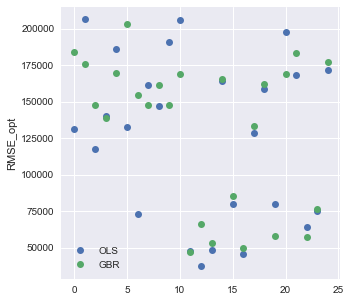

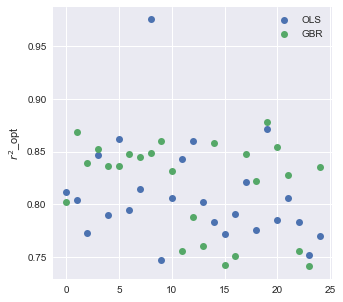

In [21]:
idx_ols = np.argmax(r2_ols, axis = 1)
idx_gbr = np.argmax(r2_gbr, axis = 1)

rmse_ols_opt = []
rmse_gbr_opt = []
r2_ols_opt = []
r2_gbr_opt = []

for ii in range(0, len(idx_ols)):
    rmse_ols_opt.append(rmse_ols[ii, idx_ols[ii]])
    rmse_gbr_opt.append(rmse_gbr[ii, idx_gbr[ii]])
    r2_ols_opt.append(r2_ols[ii, idx_ols[ii]])
    r2_gbr_opt.append(r2_gbr[ii, idx_gbr[ii]])
    
fig = plt.figure(figsize = (5, 5))
plt.plot(rmse_ols_opt, 'o')
plt.plot(rmse_gbr_opt, 'o')
plt.legend(('OLS', 'GBR'))
plt.ylabel('RMSE_opt')

fig = plt.figure(figsize = (5, 5))
plt.plot(r2_ols_opt, 'o')
plt.plot(r2_gbr_opt, 'o')
plt.legend(('OLS', 'GBR'))
plt.ylabel('$r^2$_opt')
    
rmse_ols_opt = np.median(rmse_ols_opt)
rmse_gbr_opt = np.median(rmse_gbr_opt)
r2_ols_opt = np.median(r2_ols_opt)
r2_gbr_opt = np.median(r2_gbr_opt)

print('Median OLS RMSE: ', rmse_ols_opt)
print('Median OLS r^2: ', r2_ols_opt)
print('Median GBR RMSE: ', rmse_gbr_opt)
print('Median GBR r^2: ', r2_gbr_opt)

Great. So Using a subset can give us significantly higher r2 scores, and lower RMSE than over the entire population. So for the model itself, we will find the optimal radius for OLS and GBR, and use each method to estimate the price. Obviously the issue with this approach is that the assignment wants us to price homes ***today***, and this dataset is only valid for April 2014 - May 2015. We will make a huge assumption, which is that all home prices in Seattle have increased linearly since December 2014, and correct our estimate upward using the ratio of home prices in December, 2014 to March, 2018 from Zillow.